In [2]:
# Imports & read files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [4]:
# Get NaN counts of each column
# Attributes with NaN can be removed, or replaced by some value
print(len(train))
print(train.isna().sum())

188533
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [10]:
for i in train.columns:
    if not i == 'id':
        print(i, train[i].nunique())

brand 57
model 1897
model_year 34
milage 6651
fuel_type 7
engine 1117
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 1
price 1569


## Simple qualitative researches & hypotheses on the attributes of attributes.

### For Brand / Model / Engine:
1. Specific model of car can be manufactured by a specific brand(not for the vice versa; one brand can manufacture multiple models). So, if I use the 'Model' feature, probably I don't need the 'Brand' feature. I'll check about it later. (finished: brand feature should be dropped.)

2. Car price is determined by model and engine, and can't be determined by only one of them. Car price will vary a lot by engine/model when only regressed by model/engine, so I will use joint feature. However, I don't have to use all possible 3M combinations, because there are few engine versions for a single model. I will only consider combinations exist in the train set. But to prevent the case of unseen pair appearing in the test set, I will make separate regressor too. unseen pair will be estimated by this regressor. If completely new model/engine that is not in the train set is shown, I will use the separate regressor and 'blank' encoding. This encoding will also be used when model/engine attribute is blank in the train set, too.

### For Year:
'year' attribute can be target encoded by one column, since each categories are numerically meaningful. New years shown up can be modeled by the same method. Or, I can model quadratic / exponential scoring for how much year has passed from the year shown. Same manipulation can be applied to mileage feature, too.

### For Color features:
I don't know if color effects the car price. But public preference on colors exists, and some brands price their cars differently by colors(e.g. Tesla), even if other speculations are exactly the same. This policy can vary brand by brand. So this attribute can be encoded separately or can be paired by brand.

### For accident:
'Yes' and 'At least one' looks same. This can be binary encoded. For the blanks, it can be simply filled or encoded 'blank', but I think there are some possibilities that, car owners didn't want to report because there was an accident. Filling with 'accident happened' can be nice alternative. I need further research for this.

### For Clean Title:
Free from legal issue can mean high price. This can be binary encoded.

In [34]:
duplicate_models = train.groupby('model')['brand'].nunique() > 1

# Filter the models that have multiple brands
models_with_multiple_brands = duplicate_models[duplicate_models].index

# If there are any such cases, print them
if len(models_with_multiple_brands) > 0:
    print("Models produced by different brands:")
    for model in models_with_multiple_brands:
        brands = train[train['model'] == model]['brand'].unique()
        print(f"Model: {model}")
        print(f"Brands: {', '.join(brands)}")
        print()

Models produced by different brands:
Model: 128 i
Brands: BMW, FIAT, Chrysler

Model: 135 i
Brands: BMW, FIAT

Model: 1500 Big Horn
Brands: RAM, BMW, Ford, Dodge, Chevrolet

Model: 1500 Cheyenne
Brands: Chevrolet, RAM, Dodge

Model: 1500 Cheyenne Extended Cab
Brands: Chevrolet, RAM

Model: 1500 Classic SLT
Brands: RAM, Chevrolet, Lincoln

Model: 1500 Classic Tradesman
Brands: RAM, Chevrolet

Model: 1500 Laramie
Brands: RAM, INFINITI, Chevrolet

Model: 1500 Limited
Brands: RAM, Chevrolet

Model: 1500 Longhorn
Brands: RAM, Chevrolet

Model: 1500 Rebel
Brands: RAM, Dodge

Model: 1500 SLT
Brands: RAM, Chevrolet, Dodge

Model: 1500 Sport
Brands: RAM, Chevrolet, Dodge

Model: 1500 TRX
Brands: RAM, Lexus

Model: 200 C
Brands: Chrysler, Dodge, Subaru

Model: 228 i
Brands: BMW, Subaru

Model: 240SX Base
Brands: Nissan, Chevrolet, BMW

Model: 2500 Big Horn
Brands: RAM, Toyota, Chevrolet, Dodge, BMW, Ford

Model: 2500 Laramie
Brands: RAM, Lexus, Chevrolet

Model: 2500 SLT
Brands: RAM, Chevrolet



**Fact** : Some model classification is a mess. for example, '911 carrera' is a Porsche brand, but the data shows Porsche, Ford, Aston, Lincoln, Mercedes-Benz, Kia, Hyundai for the manufacturers of the car. This means brand attribute should be removed to prevent misclassification, and I should use model as a implication of brand.

In [66]:
print(train['fuel_type'].value_counts().to_string())

Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15


In [54]:
# Show all rows in train dataframe that has price higher than 1000000
# cols = ['brand', 'price', 'model', 'model_year']
# print(train[train['price'] > 500000].loc[:, cols].sort_values(by='price', ascending=False))
print(train[train['price'] < 3000])

            id          brand                      model  model_year  milage  \
348        348     Volkswagen                 Eurovan MV        2001  121800   
456        456           Ford      F-250 XL SuperCab H/D        1997   90400   
462        462  Mercedes-Benz              Sprinter 2500        2004  158366   
758        758        Pontiac          Firebird Trans Am        2001  150000   
1044      1044           Jeep                 Cherokee X        2018   64549   
...        ...            ...                        ...         ...     ...   
186854  186854     Volkswagen             New Beetle GLS        2001   46508   
187603  187603        Hyundai                  Sonata SE        2013   87001   
187838  187838          Dodge  Ram 1500 Laramie Mega Cab        2010  155000   
187916  187916       Chrysler                  300C Base        2011  117292   
188475  188475         Toyota                  Matrix XR        2000  185000   

            fuel_type                  

**Fact** : Some car prices are definitely abnormal. There are not many of them but can make crucial consequences if the anomaly is huge. For example, brand new Ford F-150 XLT in the first row is sold around $70k according to the internet, and this data is telling me that same model used for 2 years is sold at almost $3M, which is more than 40 times higher than the new one. I need more research to balance this anomaly. maybe web crawling? delete all rows that has price upper than / lower than some amount?

Plus, some car price are abnormaly low. 2 year old Jeep Gladiator Rubicon is about $3K, but the new one is $30K. down by -90% in 2 years? what happened? Huge accidents? Used as a collateral? - but I think this is absolutely possible compared to cases above, though it's not common.

In [58]:
# print all unique context of transmission column with its count

unique_transmissions = train['transmission'].value_counts()

print(unique_transmissions)


A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission                        

**Fact** : I can see a lot of (semi) duplicates in transmission column. For example, all '8-Speed Automatic', '8-Speed A/T', '8-SPEED A/T', and '8-SPEED AT indicates same thing, and same for 'A/T' and 'AT' / 'M/T' and 'MT', ... so on. Definitely need some cleansing.

In [63]:
print(train['ext_col'].value_counts())
print(train['int_col'].value_counts())

Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: ext_col, Length: 319, dtype: int64
Black           107674
Beige            24495
Gray             21204
Brown             5810
Red               5145
                 ...  
Nougat Brown         7
Classic Red          7
Cobalt Blue          6
WHITE                6
ORANGE               4
Name: int_col, Length: 156, dtype: int64


**Fact**: A huge palette of 319/156 colors is shown, but most of them are a slight variation of few basic colors, so I think they can be aggergated into less then 10 categories. I will first drop all color features and (maybe) add later, after aggregating similar colors. 

In [64]:
print(train['accident'].value_counts())
print(train['clean_title'].value_counts())

None reported                             144514
At least 1 accident or damage reported     41567
Name: accident, dtype: int64
Yes    167114
Name: clean_title, dtype: int64


**Fact**: These columns are clean. Thank goodness.

brand


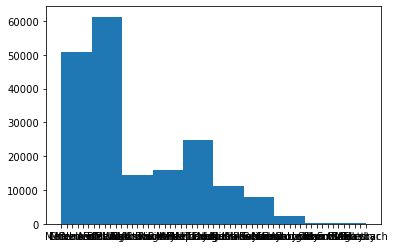

model_year


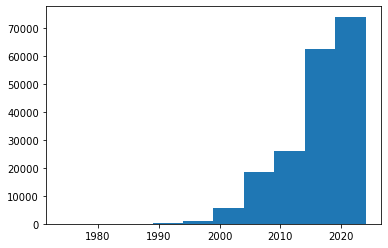

milage


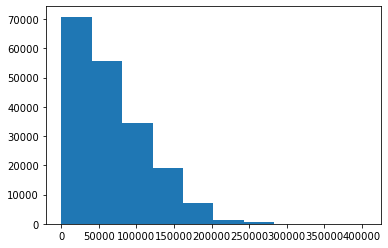

fuel_type


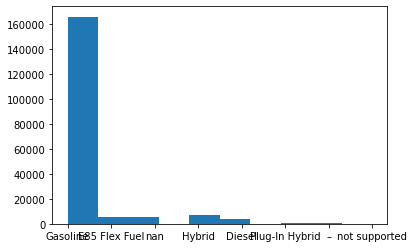

engine


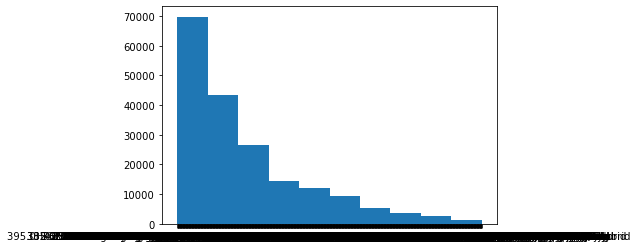

transmission


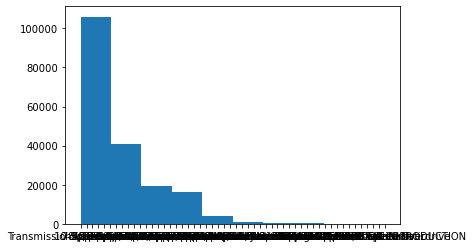

ext_col


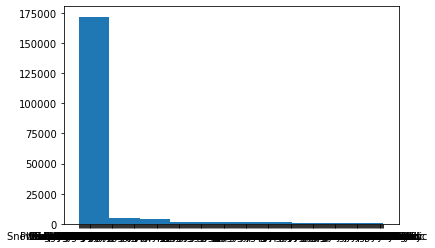

int_col


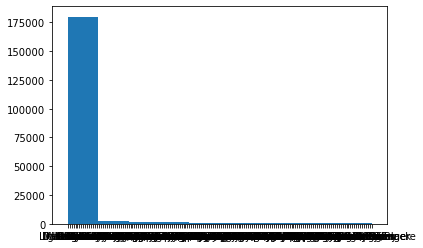

accident


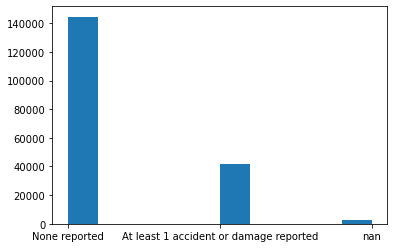

clean_title


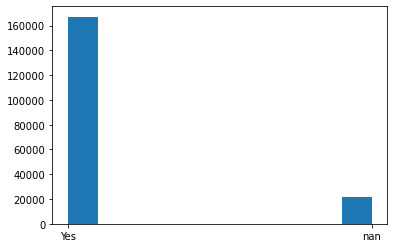

price


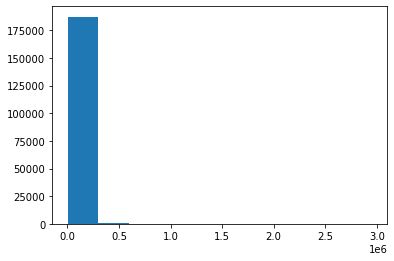

In [55]:
for i in train.columns:
    if not (i == 'id' or i == 'model'):
        print(i)
        if train[i].dtype == 'object':
            plt.hist(train[i].astype('str'))
            plt.show()
            continue
        plt.hist(train[i])
        plt.show()